# Tutorial for the autoCBH package

In [1]:
# add autocbh package to path
import sys
sys.path.append('../autocbh')

# import relevant rdkit 
from rdkit import Chem
# drawing tools used for CBH.buildCBH visualization
from rdkit.Chem import Draw, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
from IPython.display import SVG, display

# Import CBH generator
from CBH import buildCBH
from calcCBH import calcCBH
from TN import thermochemical_network, visualize
from UQ import uncertainty_quantification

# only needed for np.inf example for now
import numpy as np
from numpy import inf

# autoCBH directory structure

```
autoCBH
├── autocbh/
│   ├── data/
│   │   ├── molData.py
│   ├── CBH.py
│   │   ├── [class] buildCBH 
│   ├── calcCBH.py
│   │   ├── [class] calcCBH
│   ├── hrxnHelpers.py
│   ├── TN.py
│   │   ├── [class] thermochemical_network
│   │   ├── [func] visualize
│   ├── UQ.py
│   │   ├── [class] thermochemical_network
├── data/
│   ├── *data/
│   ├── *.yaml
├── examples/
│   ├── *.ipynb  (you are here)
```

# CBH Module
Main module which is used to generate CBH schemes. It contains the $\texttt{buildCBH}$ class which is the true driver. It generates cbh reactants and products in separate dictionaries assuming target molecule has stoichiometric coefficient = 1:

```
buildCBH.cbh_rcts = {cbh_rung [int] : {cbh_product [str] : reference_coeff [int/float] } }
buildCBH.cbh_pdts = {cbh_rung [int] : {cbh_reactant [str] : reference_coeff [int/float] } }
```

### Propane CBH example
Let's start with a simple example: propane (smiles string = 'CCC') with hydrogenated saturation.

In [2]:
cbh = buildCBH(smiles='CCC', 
               # below are optional with defaults
               saturate='H', # default = 1 --> can use string version of element (i.e., 'H')
               allow_overshoot=False, # default = False 
               ignore_F2=True, # default = True
               surface_smiles=None) # default = None

You can access important attributes such as the reactants and products. We see that there are only 2 CBH rungs.

In [3]:
cbh.cbh_rcts, cbh.cbh_pdts

({1: {'C': 1}, 0: {'[H][H]': 2.0}}, {0: {'C': 3}, 1: {'CC': 2}})

Let's visualize this


-----------------------------------------------------------------------------------------------------

CBH RUNG 0

Reactants:


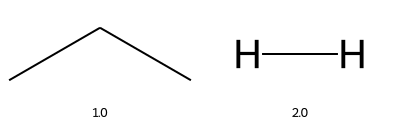


Products:


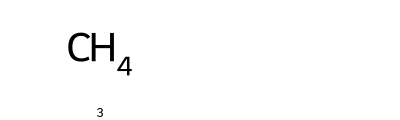


-----------------------------------------------------------------------------------------------------

CBH RUNG 1

Reactants:


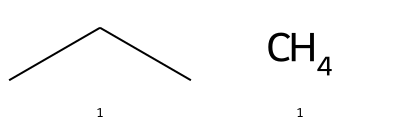


Products:


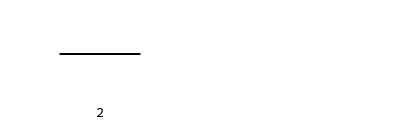

In [4]:
cbh.visualize()
# you can specify specific rungs you want by giving an [int] as an argument (i.e., cbh.visualize(1) --> CBH-1)
# if you give it '-1' you'll get the highest rung

### Fluorinated Species Example
Let's try some PFAS species: GenX

In [2]:
# RDKit's Chem module has useful functions like rdkit.Chem.MolFromSmiles() to get molecule object from a smiles string
# rdkit.Chem.CanonSmiles() is also used throughout the package to get the canonical smiles string

genx = 'O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)(F))C(F)(F)(F)'
Chem.CanonSmiles(genx)

'O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F'

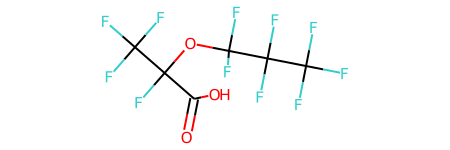

In [6]:
Chem.MolFromSmiles(genx)

In [7]:
cbh = buildCBH(genx, 
               'F', # can use the [int]: 9
               allow_overshoot=True, # not relevant here
               ignore_F2=True, # CBH-0 will not include F2 and instead use a reaction dependent on CF4
               surface_smiles=None # not relevant here
              )
'CBH RCTS:', cbh.cbh_rcts, 'CBH PDTS:', cbh.cbh_pdts

('CBH RCTS:',
 {1: {'FC(F)(F)F': 6, 'O': 1},
  0: {'[H][H]': 9.0},
  2: {'OC(F)(F)F': 2, 'FC(F)(F)C(F)(F)F': 2},
  3: {'FC(F)(F)OC(F)(F)F': 1,
   'OC(F)(F)C(F)(F)F': 1,
   'OC(F)(C(F)(F)F)C(F)(F)F': 1},
  4: {'FC(F)(F)OC(F)(F)C(F)(F)F': 1, 'FC(F)(F)OC(F)(C(F)(F)F)C(F)(F)F': 1},
  5: {'FC(F)(F)C(F)(F)OC(F)(C(F)(F)F)C(F)(F)F': 1}},
 'CBH PDTS:',
 {0: {'C': 3.25, 'O': 3, 'FC(F)(F)F': 2.75},
  1: {'O=C(F)F': 1, 'FC(F)(F)C(F)(F)F': 4, 'OC(F)(F)F': 3},
  2: {'O=C(O)C(F)(F)F': 1,
   'FC(F)(F)OC(F)(F)F': 1,
   'OC(F)(F)C(F)(F)F': 1,
   'OC(F)(C(F)(F)F)C(F)(F)F': 1,
   'FC(F)(F)C(F)(F)C(F)(F)F': 1},
  3: {'O=C(O)C(O)(F)C(F)(F)F': 1,
   'FC(F)(F)OC(F)(F)C(F)(F)F': 1,
   'OC(F)(F)C(F)(F)C(F)(F)F': 1,
   'FC(F)(F)OC(F)(C(F)(F)F)C(F)(F)F': 1},
  4: {'FC(F)(F)OC(F)(F)C(F)(F)C(F)(F)F': 1,
   'FC(F)(F)C(F)(F)OC(F)(C(F)(F)F)C(F)(F)F': 1,
   'O=C(O)C(F)(OC(F)(F)F)C(F)(F)F': 1},
  5: {'O=C(O)C(F)(OC(F)(F)C(F)(F)F)C(F)(F)F': 1,
   'FC(F)(F)C(F)(F)C(F)(F)OC(F)(C(F)(F)F)C(F)(F)F': 1}})


-----------------------------------------------------------------------------------------------------

CBH RUNG 5

Reactants:


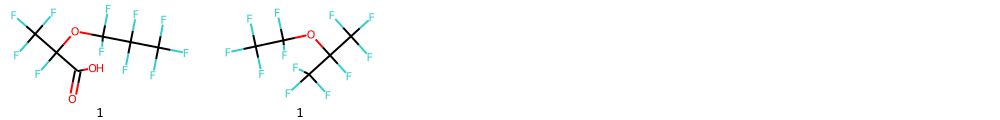


Products:


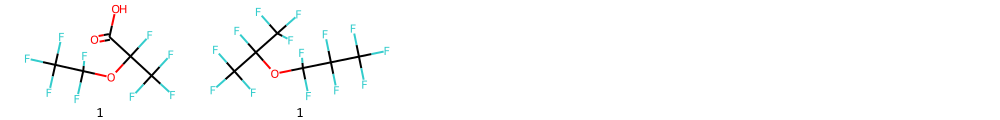

In [8]:
cbh.visualize(-1)

### Examples of allow_overshoot and ignore_F2

##### 1) allow_overshoot
Molecule = CH3CF2CH3

If you overshoot this, you will generate CF3CF2CF3 with CBH which is a larger molecule.
Sometimes you want this since you might have experimental values for CF3CF2CF3, but not for CH3CF2CH3.
Allowing overshoot in this case will let you use this experimental value and thus use a more accurate CBH rung.




-----------------------------------------------------------------------------------------------------

CBH RUNG 3

Reactants:


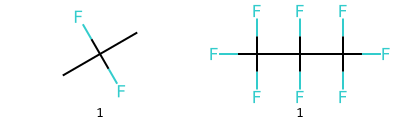


Products:


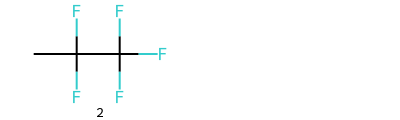

In [9]:
# allow overshoot (default)
buildCBH('CC(F)(F)C', 9, allow_overshoot=True).visualize(-1)


-----------------------------------------------------------------------------------------------------

CBH RUNG 1

Reactants:


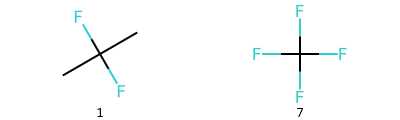


Products:


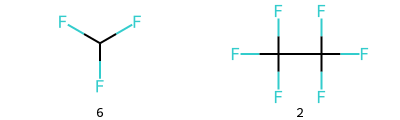

In [10]:
# disallow overshoot
buildCBH('CC(F)(F)C', 9, allow_overshoot=False).visualize(-1)

##### 2) ignore_F2
This only applies to CBH-F-0 and doesn't affect higher CBH rungs. 

This uses the following formula instead of the classical CBH-F-0 rung that would include F2 as a reactant.

$(a - \frac{c}{4})\text{CH}_4 + b\text{H}_2\text{O} + \frac{c}{4}\text{CF}_4 + (\frac{d}{2} - 2a - b + \frac{c}{2})\text{H}_2 --> \text{C}_a\text{O}_b\text{F}_c\text{H}_d$


-----------------------------------------------------------------------------------------------------

CBH RUNG 0

Reactants:


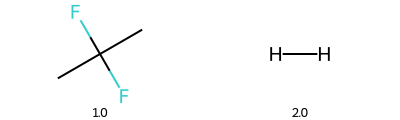


Products:


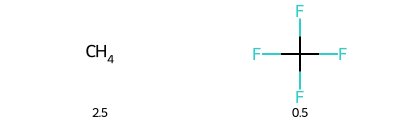

In [11]:
# don't use F2 in CBH-F-0 (default and preferred)
buildCBH('CC(F)(F)C', 9, ignore_F2=True).visualize(0)


-----------------------------------------------------------------------------------------------------

CBH RUNG 0

Reactants:


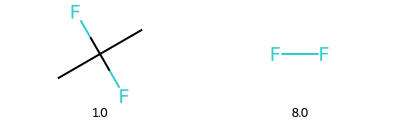


Products:


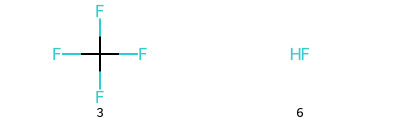

In [12]:
# use F2 in CBH-F-0
buildCBH('CC(F)(F)C', 9, ignore_F2=False).visualize(0)

# TN Module
## Thermochemical Network
It is useful to generate a thermochemical network initially to see what species you might need to compute. You are restricted by the number of QM levels of theory that are available to you as higher CBH rungs are linear combinations of lower ones so you likely will not be able to use the highest CBH rungs for large molecules. Nonetheless, it is useful to help plan what species' energies you need to compute.

In [4]:
tn = thermochemical_network([genx, 'FC(F)(F)OC(F)C(F)(F)F'], 
                       max_rung=inf, # can set max rung (default = np.inf)
                       saturate=1, # same rules as before
                       surface_smiles=None) # doesn't apply here

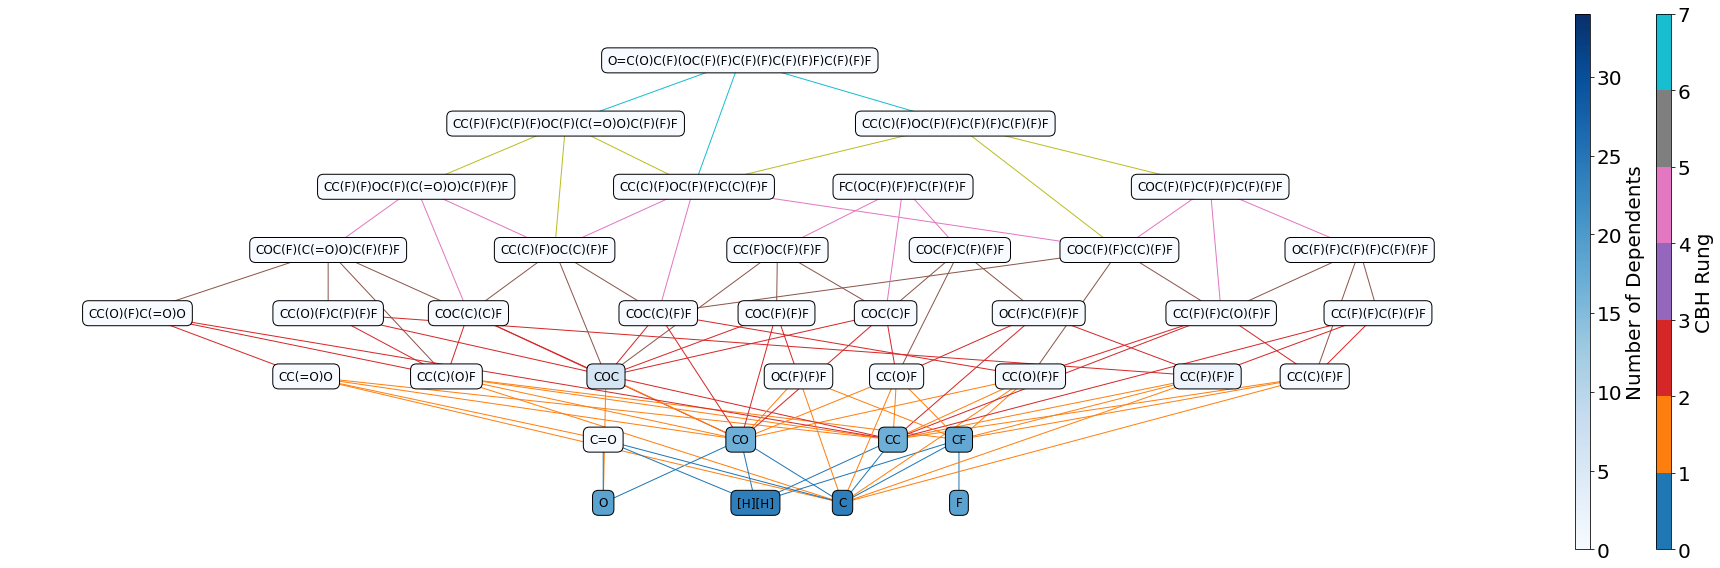

In [5]:
# this method is a wrapper for the TN.visualize function
# both can visualize any networkx graph you want
tn.visualize() # There are a lot of arguments you can use...but there are so many settings might get annoying

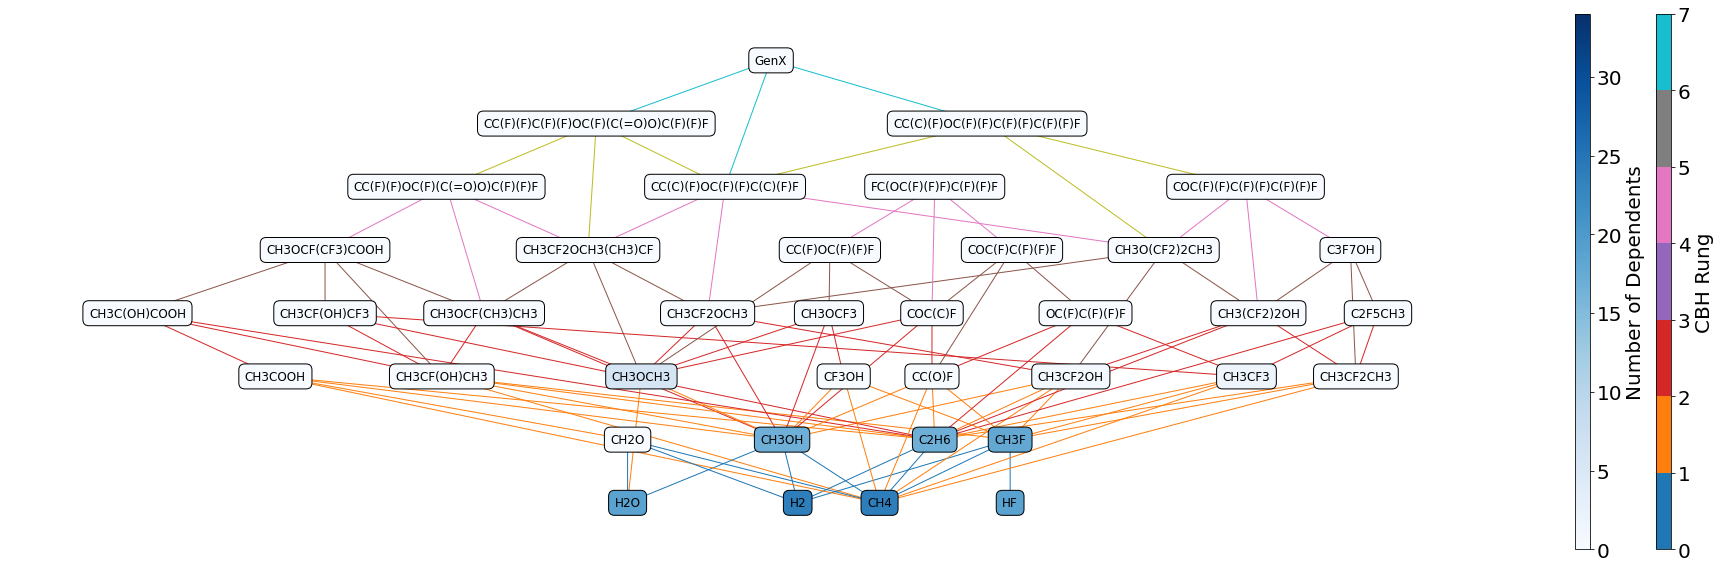

In [6]:
# SMILES strings are annoying to read. If you give it a yaml file or a dictionary holding a mapping of smiles
# strings to/from names you like, it can be easier 
tn.visualize(relabel_node_mapping='../data/alias_manual_2.yaml', 
             reverse_relabel_node_mapping=True)

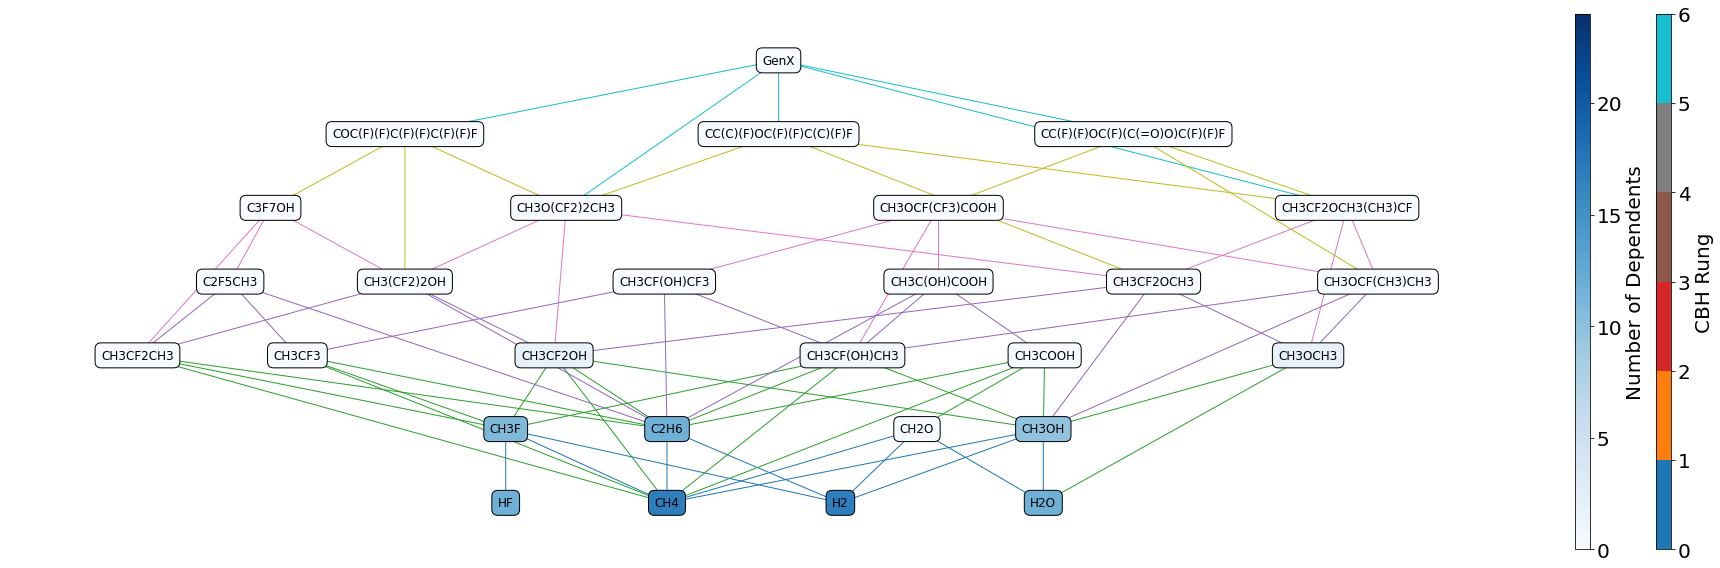

In [7]:
# It's unlikely we go higher than say CBH-4-H (this is just a guess for example)
# lets visualize that
# there are some bugs with the color scheme.............
tn = thermochemical_network(genx, 
                       max_rung=5, # can set max rung (default = np.inf)
                       saturate=1, # same rules as before
                       surface_smiles=None) # doesn't apply here
tn.visualize(relabel_node_mapping='../data/alias_manual_2.yaml', 
             reverse_relabel_node_mapping=True)

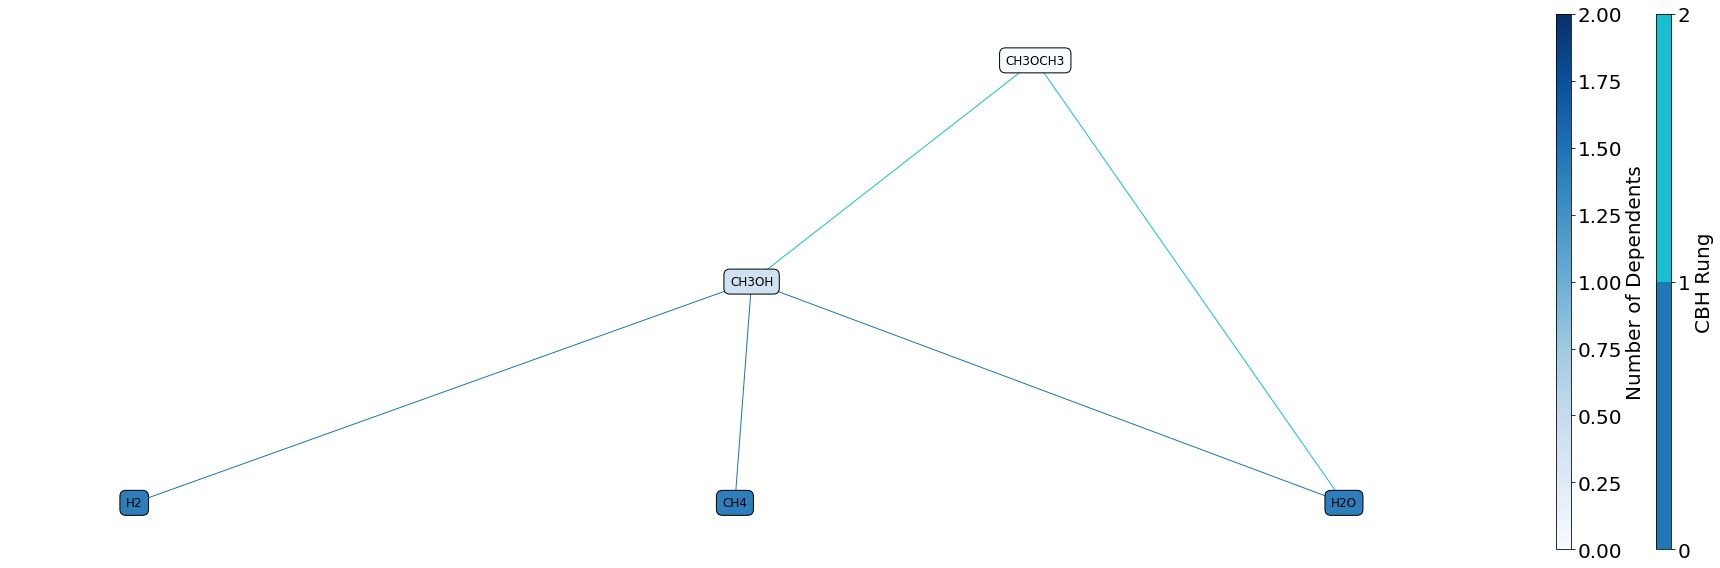

In [8]:
# We can also visualize subgraphs easily (i.e., CH3OCH3)
visualize(tn.descendent_subgraph_of('COC'),
          relabel_node_mapping='../data/alias_manual_2.yaml', 
          reverse_relabel_node_mapping=True)

# calcCBH Module
Actually calculating heats of formation.

Data is either completely found in a pkl file (dictionary structure) or individual yaml files for each molecule.
Data structure must map SMILES string to each type of QM energy and experimental heats of formation, if applicable.

For these examples, data is found at : "../autocbh/data/pfas_energies.pkl"

In [27]:
# Initialize module
c = calcCBH(methods=[], # it will automatically use all available methods unless keys specified (default=[])
            dataframe_path='../data/pfas_energies.pkl', # supply pickled dataframe 
            method_keys_path='../data/methods_keys.yaml', # supply yaml file mapping method names to each QM energy column name
            rankings_path='../data/rankings.yaml', # supply yaml file mapping each method to a level of theory ranking
            alternative_rxn_path=None, # if you have alternative reactions you want to use (default=None)
            force_generate_database=None, # we don't do this since we already give a dataframe, but can make a df using a molecular database
            force_generate_alternative_rxn=None, # we don't do this here
            zero_out_heats=True) # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan

The 'calcCBH.energies' attribute holds the dataframe used to compute and store heats of formation. At the beginning, all species with unknown heats of formation must start with the following:
- 'DfH' column set to 0.0
- 'DrxnH' column set to 0.0
- 'source' column set to NaN (np.nan)

If desired, this can be done with the 'zero_out_heats' keyword argument.

In [28]:
c.energies # what dataframe looks like initially

,avqz,av5z,zpe,ci_DK,ci_NREL,core_0_tz,core_X_tz,core_0_qz,core_X_qz,ccT,...,m062x_zpe,m062x_E0,m062x_dlpno,wb97xd_zpe,wb97xd_E0,wb97xd_dlpno,DfH,uncertainty,source,DrxnH
smiles,,,,,,,,,,,,,,,,,,,,,
F,-100.374607,-100.385414,0.009516,-100.418439,-100.336980,-100.399909,-100.343580,-100.438007,-100.375659,-100.228149,...,0.009519,-100.438867,-100.377249,0.009499,-100.446863,-100.377250,-272.680000,0.019000,ATcT,0.000000
O,-76.361486,-76.369349,0.021537,-76.374215,-76.325214,-76.389795,-76.335691,-76.420950,-76.361296,-76.241167,...,0.021458,-76.385727,-76.363501,0.021458,-76.385727,-76.363501,-238.898000,0.025000,ATcT,0.000000
[H][H],-1.173800,-1.174223,0.010044,-1.172645,-1.172636,-1.172337,-1.172337,-1.173796,-1.173796,-1.163447,...,0.010179,-1.158688,-1.173901,0.010105,-1.166498,-1.173906,0.000000,0.000000,ATcT,0.000000
C,-40.450902,-40.454546,0.044805,-40.439335,-40.425254,-40.488984,-40.439118,-40.505899,-40.451355,-40.387070,...,0.044982,-40.456434,-40.451844,0.044881,-40.474939,-40.451847,-66.551000,0.048000,ATcT,0.000000
CF,-139.604415,-139.618802,0.039489,-139.622789,-139.527270,-139.670116,-139.564240,-139.722928,-139.606438,-139.407026,...,0.039685,-139.699152,-139.607852,0.039427,-139.715731,-139.607844,-227.480000,0.230000,ATcT,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.094113,-1864.282055,-1862.658045,0.091895,-1864.309509,-1862.657796,0.000000,NaN,NaN,0.000000
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.152474,-1506.531569,-1505.243417,0.150776,-1506.574464,-1505.243325,0.000000,NaN,NaN,0.000000
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.129663,-1804.304461,-1802.743266,0.127537,-1804.340926,NaN,0.000000,NaN,NaN,0.000000


In [29]:
c.methods_keys_dict

{'anl0': ['av5z',
  'core_X_qz',
  'core_0_qz',
  'core_X_tz',
  'ci_DK',
  'ccT',
  'core_0_tz',
  'zpe_harm',
  'avqz',
  'zpe',
  'ci_NREL',
  'ccQ',
  'zpe_anharm'],
 'b2plypd3': ['b2plypd3_E0'],
 'f12b': ['b2plypd3_zpe', 'f12b'],
 'm062x': ['m062x_E0'],
 'm062x_dlpno': ['m062x_zpe', 'm062x_dlpno'],
 'wb97xd': ['wb97xd_E0'],
 'wb97xd_dlpno': ['wb97xd_zpe', 'wb97xd_dlpno']}

In [30]:
c.rankings

{1: ['ATcT', 'exp'],
 2: ['anl0'],
 3: ['f12b'],
 4: ['m062x_dlpno', 'wb97xd_dlpno'],
 6: ['b2plypd3'],
 7: ['m062x', 'wb97xd']}

In [31]:
# This function modifies the calcCBH.energies dataframe attribute in place
# You can see the results there as well
c.calc_Hf(saturate=[1], # only use CBH-H
          priority='abs_coeff', # only useful if you use multiple saturations or add in alt_rxns
          max_rung= None, # can choose a maximum rung, otherwise will do highest possible
          alt_rxn_option=None,
          surface_smiles=None)

Process completed with errors in 19 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


,DfH,DrxnH,source
smiles,,,
F,-272.680000,0.000000,ATcT
O,-238.898000,0.000000,ATcT
[H][H],0.000000,0.000000,ATcT
C,-66.551000,0.000000,ATcT
CF,-227.480000,0.000000,ATcT
...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3357.674522,1.715739,CBH-4-H//wb97xd_dlpno+m062x_dlpno
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-2589.115325,7.878635,CBH-4-H//wb97xd_dlpno+m062x_dlpno
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3175.827851,3.287536,CBH-4-H//m062x_dlpno


In [24]:
# print any errors or reasoning for not using best level of theory
c.print_errors()

OC(F)(C(F)(F)F)C(F)(F)F:

	All precursor species for CBH-3-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-2-H.
	Moving down to CBH-2-H.


O=C(O)C(O)(F)C(F)(F)F:

	All precursor species for CBH-3-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-2-H.
	Moving down to CBH-2-H.


FC(F)(F)OC(F)(F)C(F)(F)F:

	All precursor species for CBH-4-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-3-H.
	Moving down to CBH-3-H.


COC(F)(C(F)(F)F)C(F)(F)F:

	All precursor species for CBH-3-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-2-H.
	Moving down to CBH-2-H.


FC(F)(F)C(F)(F)C(F)(F)C(F)(F)F:

	All precursor species for CBH-4-H had the same level o

### Only using some lower level QM methods
When we only use low level QM method: DLPNO//M062X, we see that we are generally limited low CBH levels

In [32]:
# Initialize module
c = calcCBH(methods=['m062x_dlpno'], # CHANGED
            dataframe_path='../data/pfas_energies.pkl', # supply pickled dataframe 
            method_keys_path='../data/methods_keys.yaml', # supply yaml file mapping method names to each QM energy column name
            rankings_path='../data/rankings.yaml', # supply yaml file mapping each method to a level of theory ranking
            zero_out_heats=True) # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan

In [33]:
c.methods_keys_dict

{'m062x_dlpno': ['m062x_zpe', 'm062x_dlpno']}

In [34]:
c.calc_Hf(saturate=[1], # only use CBH-H
          max_rung= None, # can choose a maximum rung, otherwise will do highest possible
          alt_rxn_option=None,
          surface_smiles=None)

Process completed with errors in 26 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


,DfH,DrxnH,source
smiles,,,
F,-272.680000,0.000000,ATcT
O,-238.898000,0.000000,ATcT
[H][H],0.000000,0.000000,ATcT
C,-66.551000,0.000000,ATcT
CF,-227.480000,0.000000,ATcT
...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3348.756180,696.307180,CBH-1-H//m062x_dlpno
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-2585.421846,574.849846,CBH-1-H//m062x_dlpno
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3169.928081,676.569081,CBH-1-H//m062x_dlpno


In [29]:
c.print_errors()

OC(F)(F)C(F)(F)F:

	All precursor species for CBH-2-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-1-H.
	Moving down to CBH-1-H.


CC(F)(F)C(F)(F)F:

	All precursor species for CBH-2-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-1-H.
	Moving down to CBH-1-H.


CC(O)(F)C(F)(F)F:

	All precursor species for CBH-2-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-1-H.
	Moving down to CBH-1-H.


FC(F)(F)C(F)(F)C(F)(F)F:

	All precursor species for CBH-3-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-1-H.
	Moving down to CBH-2-H.

	All precursor species for CBH-2-H had the same level of theory. 
	The reaction was decomposed into each precu

It might be a good idea to store the simplified equations in the class somewhere...increases memory but might speed things up. Also would be useful to have later on.

## Using multiple saturation schemes
Initialization is the same as the first case.

In [30]:
# Initialize class
c = calcCBH(methods=[], # it will automatically use all available methods unless keys specified (default=[])
            dataframe_path='../data/pfas_energies.pkl', # supply pickled dataframe 
            method_keys_path='../data/methods_keys.yaml', # supply yaml file mapping method names to each QM energy column name
            rankings_path='../data/rankings.yaml', # supply yaml file mapping each method to a level of theory ranking
            zero_out_heats=True) # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan
c.calc_Hf(saturate=[1, 9], # Use both CBH-H and CBH-F schemes
          priority='abs_coeff') # Absolute coefficient priority scheme

Process completed with errors in 20 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


,DfH,DrxnH,source
smiles,,,
F,-272.680000,0.000000,ATcT
O,-238.898000,0.000000,ATcT
[H][H],0.000000,0.000000,ATcT
C,-66.551000,0.000000,ATcT
CF,-227.480000,0.000000,ATcT
...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3371.838212,2.142903,CBH-7-H//m062x_dlpno+wb97xd_dlpno
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-2579.523370,2.145206,"CBHavg-(4-H, 6-F)//m062x_dlpno+wb97xd_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3174.284178,1.008597,CBH-7-H//m062x_dlpno


In [31]:
# You need to reinitalize the class if you want to try calc_Hf again
# the reason for this is because it computes heats of formation for species with np.nan as their 'source'
# if 'source' is already computed, it skips it

c = calcCBH(methods=[], # it will automatically use all available methods unless keys specified (default=[])
            dataframe_path='../data/pfas_energies.pkl', # supply pickled dataframe 
            method_keys_path='../data/methods_keys.yaml', # supply yaml file mapping method names to each QM energy column name
            rankings_path='../data/rankings.yaml', # supply yaml file mapping each method to a level of theory ranking
            zero_out_heats=True) # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan
c.calc_Hf(saturate=[1, 9], # Use both CBH-H and CBH-F schemes
          priority='rel_coeff') # relative coefficient priority scheme

Process completed with errors in 22 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


,DfH,DrxnH,source
smiles,,,
F,-272.680000,0.000000,ATcT
O,-238.898000,0.000000,ATcT
[H][H],0.000000,0.000000,ATcT
C,-66.551000,0.000000,ATcT
CF,-227.480000,0.000000,ATcT
...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3382.594855,2.032257,"CBHavg-(4-H, 3-F)//m062x_dlpno+wb97xd_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-2615.259675,2.145206,"CBHavg-(4-H, 6-F)//m062x_dlpno+wb97xd_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3205.459270,0.400158,"CBHavg-(4-H, 6-F)//m062x_dlpno"


### Include some "alternative" (manually-derived) reactions

In [32]:
# You need to reinitalize the class if you want to try calc_Hf again
# the reason for this is because it computes heats of formation for species with np.nan as their 'source'
# if 'source' is already computed, it skips it

c = calcCBH(methods=[], 
            dataframe_path='../data/pfas_energies.pkl', 
            method_keys_path='../data/methods_keys.yaml', 
            rankings_path='../data/rankings.yaml', 
            alternative_rxn_path='../data/alternative_rxn_v5.yaml',
            zero_out_heats=True) # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan
c.calc_Hf(saturate=[1, 9], # Use both CBH-H and CBH-F schemes
          priority='rel_coeff', # relative coefficient priority scheme
          alt_rxn_option='best_alt') # default is 'ignore'

Process completed with errors in 21 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


,DfH,DrxnH,source
smiles,,,
F,-272.680000,0.000000,ATcT
O,-238.898000,0.000000,ATcT
[H][H],0.000000,0.000000,ATcT
C,-66.551000,0.000000,ATcT
CF,-227.480000,0.000000,ATcT
...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3377.267864,2.032257,"CBHavg-(4-H, 3-F)//m062x_dlpno+wb97xd_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-2609.921824,2.145206,"CBHavg-(4-H, 6-F)//m062x_dlpno+wb97xd_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3199.262257,0.400158,"CBHavg-(4-H, 6-F)//m062x_dlpno"


In [23]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 1):
    print(c.energies.loc[:,'source'])

smiles
F                                                                                                    ATcT
O                                                                                                    ATcT
[H][H]                                                                                               ATcT
C                                                                                                    ATcT
CF                                                                                                   ATcT
CO                                                                                                   ATcT
FCF                                                                                                  ATcT
C=O                                                                                                  ATcT
FC(F)F                                                                                               ATcT
O=C(F)F                                

# Thermochemical network of calcCBH module

In [33]:
c = calcCBH(methods=[], # it will automatically use all available methods unless keys specified (default=[])
            dataframe_path='../data/pfas_energies.pkl', # supply pickled dataframe 
            method_keys_path='../data/methods_keys.yaml', # supply yaml file mapping method names to each QM energy column name
            rankings_path='../data/rankings.yaml', # supply yaml file mapping each method to a level of theory ranking
            zero_out_heats=True) # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan
c.calc_Hf(saturate=[1, 9], # Use both CBH-H and CBH-F schemes
          priority='rel_coeff') # relative coefficient priority scheme

tn = thermochemical_network(c)

Process completed with errors in 22 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


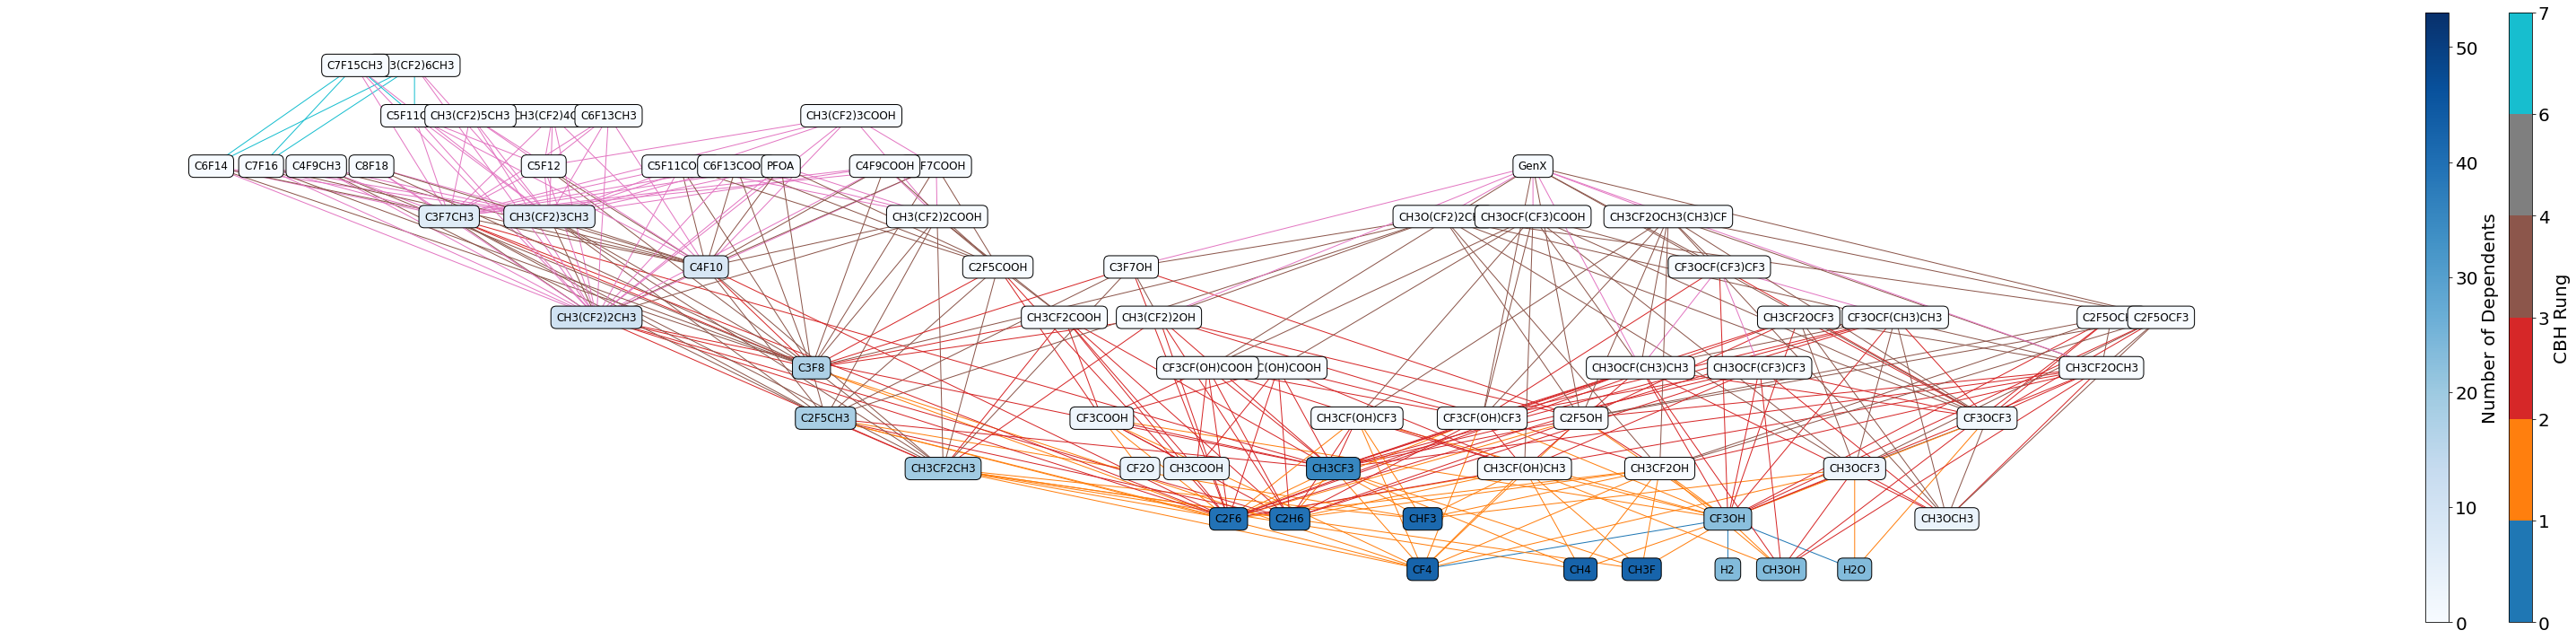

In [34]:
tn.visualize(relabel_node_mapping='../data/alias_manual_2.yaml', reverse_relabel_node_mapping=True, 
             figsize=(40,10))

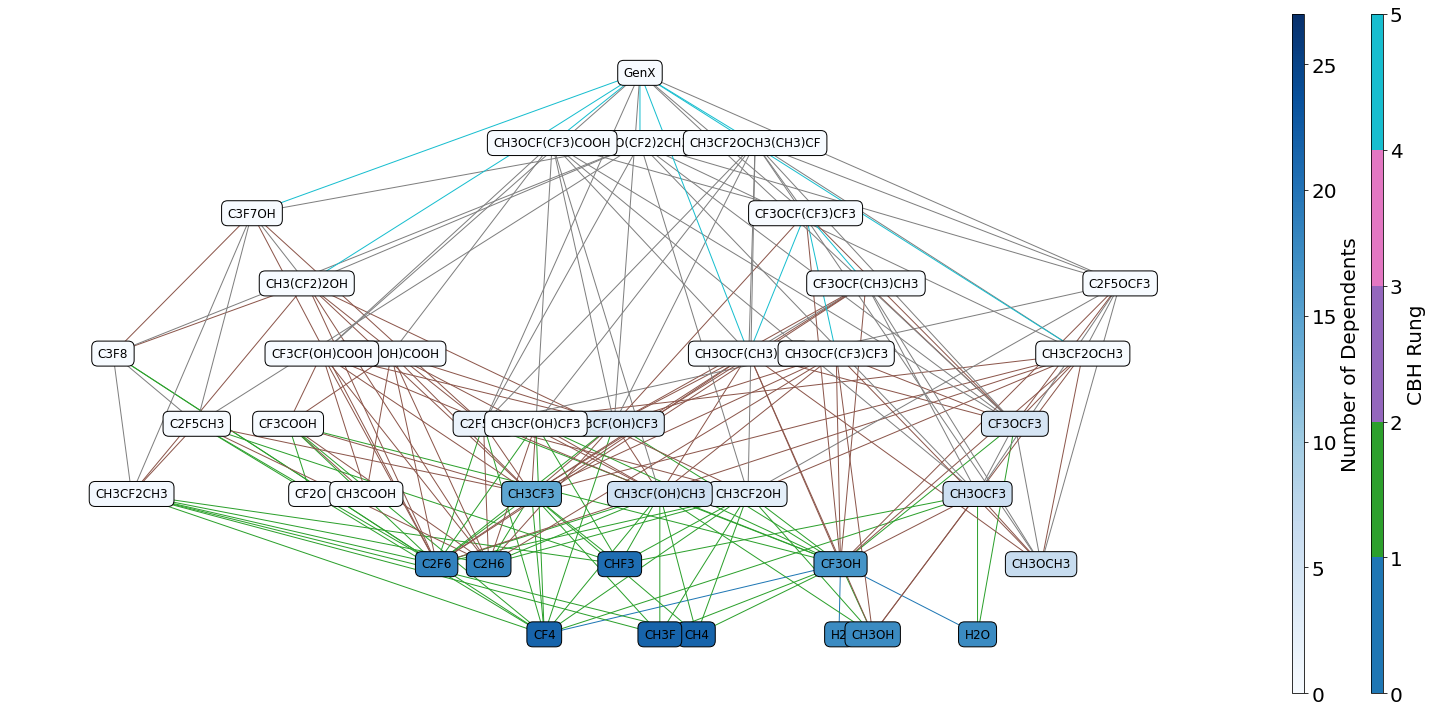

In [35]:
# lets look just at GenX subgraph!
genx = 'O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)(F))C(F)(F)(F)'
genx = Chem.CanonSmiles(genx)
visualize(tn.descendent_subgraph_of(genx), 
          relabel_node_mapping='../data/alias_manual_2.yaml', 
          reverse_relabel_node_mapping=True, 
          figsize=(20,10))

# Uncertainty Quantification

$\texttt{uncertainty_quantification}$ class is used. This first runs calcCBH internally (so it takes the same arguments), then using the computed 'source' column, it computes the heats of formation again using different intial points in a vectorized manner. Currently cannot use alternative reactions.

Results are stored in $\texttt{simulation_results}$ attribute.

### Initialize uncertainty quantification class

In [36]:
uq = uncertainty_quantification(10000, # number of simulations --> number of random points within exp uncertainty
                                dataframe_path='../data/pfas_energies.pkl', 
                                saturate=[1,9], 
                                method_keys_path='../data/methods_keys.yaml', 
                                rankings_path='../data/rankings.yaml',
                                priority='rel_coeff', 
                                alt_rxn_option="ignore")

### 1) Experimental uncertainty propagation

In [37]:
uq.run()

Process completed with errors in 22 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


Number of Species: 100%|███████████████████████████████████████████████| 53/53 [00:03<00:00, 13.72it/s]


In [38]:
uq.simulation_results.shape # shape = (num_species, num_simulations+1)
# first column is the mean experimental values

(73, 10001)

In [39]:
# order of species
uq.species

array(['F', 'O', '[H][H]', 'C', 'CF', 'CO', 'FCF', 'C=O', 'FC(F)F',
       'O=C(F)F', 'OC(F)(F)F', 'FC(F)(F)F', 'CC', 'COC', 'CCO', 'CC(=O)O',
       'CC(O)(F)F', 'CC(F)(F)F', 'COC(F)(F)F', 'CCC', 'CCOC', 'CC(C)O',
       'O=C(O)C(F)(F)F', 'OC(F)(F)C(F)(F)F', 'CCC(=O)O',
       'FC(F)(F)C(F)(F)F', 'CC(C)(F)F', 'CC(C)(O)F', 'FC(F)(F)OC(F)(F)F',
       'COC(C)(F)F', 'CC(F)(F)C(=O)O', 'CC(O)(F)C(=O)O',
       'CC(F)(F)C(F)(F)F', 'CC(F)(F)C(O)(F)F', 'CC(O)(F)C(F)(F)F',
       'CC(F)(F)OC(F)(F)F', 'COC(F)(F)C(F)(F)F', 'COC(C)(C)F',
       'O=C(O)C(F)(F)C(F)(F)F', 'O=C(O)C(O)(F)C(F)(F)F',
       'FC(F)(F)C(F)(F)C(F)(F)F', 'OC(F)(F)C(F)(F)C(F)(F)F',
       'OC(F)(C(F)(F)F)C(F)(F)F', 'CC(F)(F)C(C)(F)F',
       'FC(F)(F)OC(F)(F)C(F)(F)F', 'CC(C)(F)OC(F)(F)F',
       'COC(F)(F)C(C)(F)F', 'CC(F)(F)C(F)(F)C(=O)O',
       'COC(F)(C(=O)O)C(F)(F)F', 'CC(F)(F)C(F)(F)C(F)(F)F',
       'COC(F)(C(F)(F)F)C(F)(F)F', 'CC(C)(F)OC(C)(F)F',
       'O=C(O)C(F)(F)C(F)(F)C(F)(F)F', 'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)F

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml

#### example of how to visualize this

In [42]:
normalized_simresults = uq.simulation_results - np.expand_dims(uq.simulation_results.mean(axis=1), axis=-1)
df = pd.DataFrame(normalized_simresults, index=uq.species)
df

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
F,-0.000073,0.013510,-0.003022,-0.003511,0.000904,-0.002201,0.006983,-0.015859,0.023534,-0.001819,...,-0.011277,0.015823,-0.003469,-0.017825,-0.001188,0.004330,-0.007040,0.008165,-0.010061,0.010090
O,-0.000103,-0.007780,-0.005473,-0.007075,-0.010482,-0.005485,-0.020837,-0.003725,-0.002186,0.011487,...,0.000782,-0.020154,0.004898,-0.005368,0.005388,0.011168,0.021351,0.019985,0.017142,0.005308
[H][H],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
C,-0.000205,0.000740,-0.015682,0.019973,0.007581,-0.036540,0.014020,0.029024,0.044592,-0.016921,...,-0.007767,-0.027883,0.024728,0.043252,0.028610,0.009034,-0.034315,0.028765,-0.018403,0.002681
CF,0.000426,0.176306,0.093372,-0.061336,-0.250585,-0.183819,-0.161447,-0.176486,0.051525,-0.100897,...,-0.131680,-0.207097,0.267662,0.022407,-0.105281,0.034262,-0.145850,-0.039050,-0.036367,-0.014157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-0.013592,-8.687985,1.874066,3.322193,4.482399,-2.233339,1.545818,-0.168169,-6.091715,5.187069,...,-4.302426,-1.035493,-2.358432,-1.846002,8.736922,-0.943179,-5.943389,0.204994,-0.972684,1.265559
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-0.002786,-12.113332,4.362699,4.660587,7.023501,-6.029086,2.515131,-1.414635,-9.656195,7.350710,...,-6.463977,-0.425063,-2.638001,-4.086994,10.992156,-4.863696,-10.611118,1.753402,-0.041458,3.462476
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-0.007974,-11.651834,3.628392,4.474572,6.529971,-4.865105,2.357532,-0.953911,-8.912894,7.042160,...,-6.045454,-0.695524,-2.743221,-3.449110,10.936309,-3.549519,-9.438117,1.286714,-0.444839,2.836004
O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-0.009061,-11.849065,3.737766,4.745649,6.988914,-5.012538,2.396006,-0.992216,-8.981624,7.366665,...,-6.198693,-0.775194,-3.026039,-3.464808,11.455646,-3.249739,-9.695354,1.111029,-0.560659,2.938086


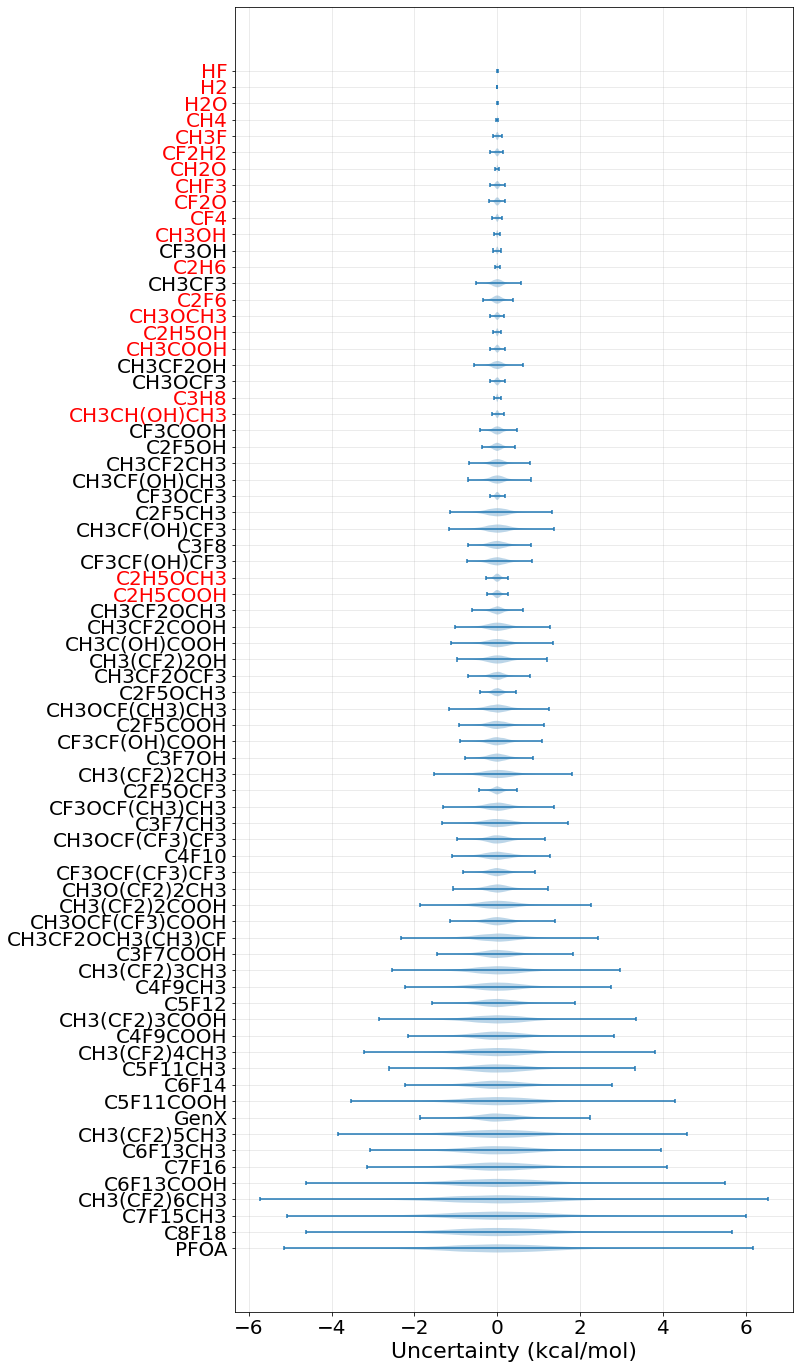

In [44]:
# load name mapping from SMILES
with open('../data/alias_manual_2.yaml', 'r') as f:
    alias = yaml.safe_load(f)
alias_rev = {v:k for k, v in alias.items()}

# generate indices by sorting by SMILES
sorted_inds = sorted(df.index.values, key=uq.simple_sort)[::-1]
alias_sorted_names = [alias_rev[s] for s in sorted_inds]

# find the experimental smiles strings --> to make them red
exp_smiles = [s for s in uq.species if len(uq.calcCBH.energies.loc[s,'source'].split('//'))==1]

# plot uncertainty
fig, ax = plt.subplots(1,1, figsize=(10,24))
ax.violinplot(df.loc[sorted_inds].T/4.184, vert=False)
ax.set_yticks(ticks=np.arange(len(alias_sorted_names))+1, labels=alias_sorted_names, fontsize=20)
plt.xticks(fontsize=20)
for s in exp_smiles:
    if alias_rev[s] in alias_sorted_names:
        ind = alias_sorted_names.index(alias_rev[s])
        ax.get_yticklabels()[ind].set_color("red")
plt.grid(True, axis='both', alpha=0.3)
plt.xlabel('Uncertainty (kcal/mol)', fontsize=22)
plt.show()

### 2) UQ for different CBH selection options (alternative rxns, rel/abs coeff)
Includes experimental uncertainty

In [45]:
uq = uncertainty_quantification(10000, # number of simulations --> number of random points within exp uncertainty
                                dataframe_path='../data/pfas_energies.pkl', 
                                saturate=[1,9], 
                                method_keys_path='../data/methods_keys.yaml', 
                                rankings_path='../data/rankings.yaml',
                                alternative_rxn_path='../data/alternative_rxn_v5.yaml',
                                priority='rel_coeff', 
                                alt_rxn_option="ignore")

In [46]:
# This will look at priority protocol
uq.run_cbh_selection() # no arguments --> all combinations of alt rxn options and priority protocol

alt rxn option: include | priority: rung: : 12it [01:53,  9.43s/it]     


[('ignore', 'abs_coeff'),
 ('ignore', 'rel_coeff'),
 ('ignore', 'rung'),
 ('best_alt', 'abs_coeff'),
 ('best_alt', 'rel_coeff'),
 ('best_alt', 'rung'),
 ('avg_alt', 'abs_coeff'),
 ('avg_alt', 'rel_coeff'),
 ('avg_alt', 'rung'),
 ('include', 'abs_coeff'),
 ('include', 'rel_coeff'),
 ('include', 'rung')]

In [47]:
uq.cbh_selection_combos

[('ignore', 'abs_coeff'),
 ('ignore', 'rel_coeff'),
 ('ignore', 'rung'),
 ('best_alt', 'abs_coeff'),
 ('best_alt', 'rel_coeff'),
 ('best_alt', 'rung'),
 ('avg_alt', 'abs_coeff'),
 ('avg_alt', 'rel_coeff'),
 ('avg_alt', 'rung'),
 ('include', 'abs_coeff'),
 ('include', 'rel_coeff'),
 ('include', 'rung')]

In [27]:
uq.simulation_results.shape # ( each combination (order above cell output or uq.cbh_selection_combos), species, num simulations )


(12, 73, 10001)

### 3) UQ for experimental uncertainty and effect of saturation atoms given: CBH selection, and reaction priority

In [2]:
uq = uncertainty_quantification(10000, # number of simulations --> number of random points within exp uncertainty
                                dataframe_path='../data/pfas_energies.pkl', 
                                saturate=[1,9], 
                                method_keys_path='../data/methods_keys.yaml', 
                                rankings_path='../data/rankings.yaml',
                                alternative_rxn_path='../data/alternative_rxn_v5.yaml',
                                priority='rel_coeff', 
                                alt_rxn_option="ignore")
uq.run_cbh_sat(sat_list=[1,9])

Saturation: [1, 9]: : 3it [00:18,  6.33s/it]


[[1], [9], [1, 9]]

In [3]:
uq.simulation_results.shape # (each saturation combination, species, num simualtions)

(3, 73, 10001)

In [4]:
uq.cbh_sat_combos

[[1], [9], [1, 9]]